In [3]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
import glob

In [4]:
#Auto formatting for the fit label
def get_fit_label(pop, pcov, fit_label=""):
    string = ["" for _ in range(len(pop))]
    for i in range(len(pop)):
        string[i] = str(fit_label[i]) + ' = ' + str(round(pop[i],2)) + ' ± ' + str(round(np.sqrt(pcov[i][i]),2))
    label = ""
    for i in string:
        if i == string[len(string)-1]:
            label += str(i)
        else: label += str(i) + ', '
    return label
def get_curve_fit(curve_fit_function,bin_centers,count,param_guess):
    popt, pcov = curve_fit(curve_fit_function, bin_centers, count,p0=param_guess,)
    x_fit = np.linspace(min(bin_centers), max(bin_centers), 500)
    y_fit = curve_fit_function(x_fit, *popt)
    return [x_fit,y_fit,popt,pcov]

def plot_logscale(data,bins,label,title,xlabel,ylabel,bool_grid,bool_plot):
    plt.hist(data, bins=bins,label=label)
    #plotting
    plt.title(title)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(bool_grid): plt.show()
    return
def plot_twoHist(data, x_range, num_bin, 
              title="", xlabel="",ylabel="Number of Events", plot=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False,
              bool_log=True,bool_xlog=False, bool_grid=True, bool_error=False,
              data_label = "data",
              mc_data = False, mc_label = "MC",bool_scaleMC=True):
    count, bin_edges = np.histogram(data, bins=np.arange(x_range[0],x_range[-1],num_bin))
    countMC, blah= np.histogram(mc_data,bin_edges)

    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]
    ErrCount1 = np.sqrt(count)
    ErrBin = (bin_centers[1]-bin_centers[0])/2  # horizontal error bars

    if(bool_scaleMC):
        # Scale MC to data
        data_in_range = ((data >= x_range[0]) & (data < x_range[-1]))
        mc_in_range = ((mc_data >= x_range[0]) & (mc_data < x_range[-1]))
        scale = np.sum(data_in_range) / np.sum(mc_in_range)
        
        print("Scaling MC by: ",scale)
        countMC = countMC * scale

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(title)
    
    if(bool_error): plt.errorbar(bin_centers, count, yerr=ErrCount1, xerr=ErrBin,
             ls='', marker='o', mfc='black', ms=4, mec='black',
             ecolor='black', label=data_label)
    else: plt.bar(bin_centers, count,color ='blue', width = ErrBin*2, label=data_label)
    
    plt.bar(bin_centers, countMC,color ='blue', width = ErrBin*2, label=mc_label)
    
    if(plot): plt.xlabel(xlabel, fontsize=15)
    if(plot): plt.ylabel(ylabel, fontsize=15)
    if(bool_log): plt.yscale('log')
    if(bool_xlog): plt.xscale('log')
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.legend(loc="upper right", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.show()


def plot_hist(data, x_range, num_bin, 
              title="", xlabel="",ylabel="Number of Events", plot=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False,
              bool_log=True,bool_xlog=False, bool_grid=True, bool_error=False,
              data_label = "data",
              mc_data = False, mc_label = "MC", bool_scaleMC = True,
              bool_returnFit = False, style_color = 'blue'
              ):
    """
    Plots a histogram of the data with optional curve fitting.
    Parameters:
    - data: The data to be plotted.
    - x_range: The range of x values for the histogram.
    - num_bin: The number of bins for the histogram.
    - title: The title of the plot.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    - plot: Whether to show the plot (default is True).
    - curve_fit_function: The function to fit the histogram data (default is False).
    - curve_fit_label: The label for the curve fit (default is an empty string).
    - param_guess: Initial guess for the curve fit parameters (default is False).
    - bool_log: Whether to use a logarithmic scale for the y-axis (default is True).
    - bool_xlog: Whether to use a logarithmic scale for the x-axis (default is False).
    """

    #Creating bins and error bars
    if(bool_xlog):
        plot_logscale(data=data,bins=np.logspace(start=np.log10(x_range[0]),stop=np.log10(x_range[-1]), num=num_bin),
                      title=title,label=data_label,xlabel=xlabel,ylabel=ylabel,
                      bool_grid=bool_grid,bool_plot=plot
                      )
        return 
    else: count, bin_edges = np.histogram(data, bins=np.arange(x_range[0],x_range[-1],num_bin))
    
    if(type(mc_data) != bool):
        plot_twoHist(data,x_range,num_bin,
                     title,xlabel,ylabel,plot,
                     curve_fit_function,curve_fit_label,param_guess,
                     bool_log,bool_xlog,bool_grid,bool_error,
                     data_label,mc_data,mc_label,bool_scaleMC
                     )
        return
    
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]
    ErrCount1 = np.sqrt(count)
    ErrBin = (bin_centers[1]-bin_centers[0])/2  # horizontal error bars
    
    #Manages curve fitting to the data
    if(curve_fit_function):
        x_fit, y_fit,popt,pcov = get_curve_fit(curve_fit_function,bin_centers,count,param_guess)
        


    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(title)
    if(curve_fit_function): plt.plot(x_fit, y_fit, 'r--', label=f'Fit: {curve_fit_label} a={popt[0]:.2f}, b={popt[1]:.2f}, c={popt[2]:.2f}')
    if(bool_error): plt.errorbar(bin_centers, count, yerr=ErrCount1, xerr=ErrBin,
             ls='', marker='o', mfc='black', ms=4, mec='black',
             ecolor='black', label=data_label)
    else: plt.bar(bin_centers, count,color =style_color, width = ErrBin*2, label=data_label)
    
    if(plot): plt.xlabel(xlabel, fontsize=15)
    if(plot): plt.ylabel(ylabel, fontsize=15)
    if(bool_log): plt.yscale('log')
    if(bool_xlog): plt.xscale('log')
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    #if(plot): plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.legend(loc="upper right", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.show()
    if(bool_returnFit): return popt

def plot_plot(datax, datay, xlim=False, ylim=False, 
              title="", xlabel="",ylabel="", 
              plot=True,bool_log_y=False, bool_log_x=False, bool_grid=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False, fit_label="", bool_returnFit = False
              ):
    
    # Plotting
    plt.title(title)
    plt.plot(datax, datay,'.',markersize=5,label='Data points')
    
    if(curve_fit_function):
        if(param_guess): popt, pcov = curve_fit(curve_fit_function, datax, datay,p0=param_guess)
        else: popt, pcov = curve_fit(curve_fit_function, datax, datay)
        # Plot fit
        x_fit = np.linspace(min(datax), max(datax), 500)
        y_fit = curve_fit_function(x_fit, *popt)
        
        plt.plot(x_fit, y_fit, 'r--', label=get_fit_label(popt, pcov, fit_label))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if(bool_log_y): plt.yscale('log')
    if(bool_log_x): plt.xscale('log')
    plt.legend()
    if(ylim): plt.ylim(ylim[0],ylim[-1])
    if(xlim): plt.xlim(xlim[0],xlim[-1])
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.show()
    if(bool_returnFit): return popt

def plot_hist2d(datax, datay, x_range=None, y_range=None, num_bin_x=10, num_bin_y=10,
                title="", xlabel="", ylabel="", data_label = "data",
                plot=True,
                bool_grid=True,
                curve_fit_function = False,fit_label="", param_guess=False, bool_returnFit = False
                ):
    
    range_xy = [x_range, y_range]
    if (x_range is None and y_range is None):
        range_xy = None

    #Manages curve fitting to the data
    if(curve_fit_function):
        x_fit, y_fit,popt,pcov = get_curve_fit(curve_fit_function,datax,datay,param_guess)    
        plt.plot(x_fit, y_fit, 'r--', label=get_fit_label(popt, pcov, fit_label))
    
    plt.hist2d(datax,datay,bins=[num_bin_x,num_bin_y] ,range=range_xy, norm=colors.LogNorm(),label= data_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if(plot): plt.legend(fancybox=True)
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.colorbar()
    if(plot): plt.show() 
    if(bool_returnFit): return popt

#Makes a scatter plot
def plot_scatter(datax, datay, xlim=False, ylim=False, 
                 title="", xlabel="",ylabel="Number of Events", 
                 plot=True, bool_grid=True
                 ):
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.scatter(datax,datay, color='blue', label='Data points')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend()
    if(ylim): plt.ylim(ylim[0],ylim[-1])
    if(xlim): plt.xlim(xlim[0],xlim[-1])
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.show()

#Makes a categorical bar chart
def plot_bar(pdgid_data, names, pdgids, title="",ylabel="Number of Events", plot=True):
    
    #Make sure everything is a np array
    pdgid_data = np.array(pdgid_data)
    names = np.array(names)
    pdgids = np.array(pdgids)

    # Count matched PDG IDs
    counts = np.array([np.sum(pdgid_data == pid) for pid in pdgids])

    # Find unmatched PDG IDs
    matched_ids = set(pdgids)
    unique_ids_in_data = set(np.unique(pdgid_data))
    unmatched_ids = sorted(unique_ids_in_data - matched_ids)

    if unmatched_ids:
        print("⚠️ Warning: The following PDG IDs were not matched to any bin:")
        print("   →", unmatched_ids)

    # Removes unmatched PDG IDs from names and counts
    mask = counts > 0
    names = names[mask]
    counts = counts[mask]
    if len(names) == 0:
        print("⚠️ Warning: No PDG IDs matched the data. No plot will be generated.")
        return

    # Plotting
    x = np.arange(len(names))
    plt.figure(figsize=(8, 5))
    plt.bar(x, counts, tick_label=names, color='blue', edgecolor='black')

    plt.xlabel("Particle Type")
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if(plot): plt.show()
def get_particle_count(data, title="mc_pdgID"):
    # Plot PDG ID
    particle_names = [
        'Photon', 'Electron', 'Muon', 'Tau',
        'Electron Neutrino', 'Muon Neutrino', 'Tau Neutrino',
        'Pion+', 'Pion-', 'Pion0',
        'Kaon+', 'Kaon-', 'Kaon0', 'Kaon0L', 'Kaon0S',
        'Neutron', 'Proton', 'Antiproton',
        'Deuteron', 'Triton', 'Alpha',
        'Lambda', 'Sigma+', 'Sigma0', 'Sigma-',
        'Xi0', 'Xi-', 'Omega-',
        'D+', 'D-', 'D0', 'D_s+', 'D_s-',
        'B+', 'B-', 'B0', 'B_s0', 'B_c+',
        'J/psi', 'Upsilon(1S)', 'Z boson', 'W+ boson', 'W- boson', 'Higgs boson', 'Gluon'
    ]

    particle_pdgs = [
        22,  # Photon
        11,  # Electron
        13,  # Muon
        15,  # Tau
        12,  # Electron neutrino
        14,  # Muon neutrino
        16,  # Tau neutrino
        211,  # Pi+
    -211,  # Pi-
        111,  # Pi0
        321,  # K+
    -321,  # K-
        311,  # K0
        130,  # K0L
        310,  # K0S
    2112,  # Neutron
    2212,  # Proton
    -2212,  # Antiproton
    1000010020, # Deuteron
    1000010030, # Triton
    1000020040, # Alpha particle (Helium-4 nucleus)
    3122,  # Lambda
    3222,  # Sigma+
    3212,  # Sigma0
    3112,  # Sigma-
    3322,  # Xi0
    3312,  # Xi-
    3334,  # Omega-
    411,   # D+
    -411,   # D-
    421,   # D0
    431,   # D_s+
    -431,   # D_s-
    521,   # B+
    -521,   # B-
    511,   # B0
    531,   # B_s0
    541,   # B_c+
    443,   # J/psi
    553,   # Upsilon(1S)
        23,  # Z boson
        24,  # W+ boson
        -24,  # W- boson
        25,  # Higgs boson
        21   # Gluon
    ]

    plot_bar(abs(data), particle_names, particle_pdgs,title)

def exponential(x, a, b,B):
    return a * np.exp(-x/b)+B

#Flattens two-dimenisional data
def flat(data, isMax=False,isLen=False,isSum = True):
    if(isMax): return np.array([np.max(i) if len(i)>0 else float('nan') for i in data])
    if(isLen): return np.array([len(i) for i in data])
    if(isSum): return np.array([np.sum(np.abs(i)) for i in data] )
    return np.array([i for sublist in data for i in sublist])
   
def get_mask(data, range, isDouble=False, makeDoubleMask=False):
    if(isDouble): return np.array( [any(range[0] <= i <= range[-1] for i in event)for event in data])
    return np.array( (data >= range[0]) & (data <= range[-1]) )

def get_RDF(pattern = "*.root", path_name = "/data/ahicks3/projects/eos/michelElectron/MC/", ttree_name = "output" ):
    try:
        file_list = glob.glob(path_name+pattern)
    except:
        print("Glob Failed")
    try:
        rdf_x = r.RDataFrame(ttree_name, file_list)
        return rdf_x
    except:
        print("ERROR: Creation of rdf failed")
        return 0

In [5]:
# Create RDataFrame from the events tree of the input file.
mc417_rdf = get_RDF(path_name="/data/ahicks3/projects/eos/michelElectron/MC/MC_9M_Run417_rerun_Total300_DIR/")

# Extract mc_branches
mc417_nhits = mc417_rdf.AsNumpy(columns=["digitNhits"])["digitNhits"]
mc417_pdgID = mc417_rdf.AsNumpy(columns=["mcpdg"])["mcpdg"]
mc417_charge = np.array(mc417_rdf.AsNumpy(columns=["digitCharge"])["digitCharge"])
mc417_time = mc417_rdf.AsNumpy(columns=["timeSinceLastTrigger_us"])["timeSinceLastTrigger_us"]
mc417_energy = mc417_rdf.AsNumpy(columns=["mcke"])["mcke"]

# Plot PDG ID
#get_particle_count(abs(mc_pdgID))
print(len(mc417_pdgID))

9000937


In [6]:
mc417_pmtID = mc417_rdf.AsNumpy(columns=["digitPMTID"])["digitPMTID"]

In [ ]:
sflat_mc417_charge = flat(mc417_charge,isSum=False)
sflat_mc417_pmtID = flat(mc417_pmtID, isSum=False)

In [ ]:
plot_scatter(datax = sflat_mc417_pmtID, xlabel="PMT ID",
             datay=sflat_mc417_charge, ylabel = "Charge [pC]",
             title = "Individual Charge vs. PMT ID"
             )

NameError: name 'plot_scatter' is not defined

In [ ]:
flat_mc417_energy = flat( mc417_energy)
flat_mc417_charge = flat( mc417_charge)

In [ ]:
bool_mcCharge = get_mask(flat_mc417_charge,[00,2100])
bool_mc417 = bool_mcCharge

In [ ]:
#plot_hist(flat( mc_charge,isSum=True),[0,2000],25,title="digitCharge",xlabel="Total Charge [pC]",data_label="MC")

In [ ]:
#plot_hist(flat(mc_energy,isSum=True),[0,100],1,title="mcke",xlabel="Energy [MeV]",data_label="MC")

/tmp/ipykernel_212939/1092352945.py:194: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  if(plot): plt.legend(fancybox=True)


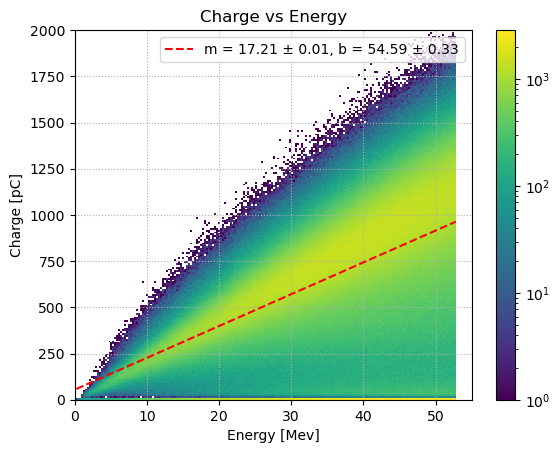

17.211990830835916 54.59264047229865


In [ ]:
def linear(x, m, b):
    return (m * (x)) + b

def quad(x, a,b,c):
    return a*x**2 + b*x + c

#This should be done after correlation is matched
"""
m, b = plot_plot(flat_mc417_charge, flat_mc417_energy,
          title="Charge vs Energy",
          xlabel="Energy [MeV]",
          ylabel="Charge [pC]",
          curve_fit_function=linear,
          curve_fit_label="Linear Fit",
          param_guess=[0,19],
          fit_label=["m","b"], bool_returnFit=True)
"""

m,b = plot_hist2d(datay= flat_mc417_charge[bool_mc417],datax= flat_mc417_energy[bool_mc417],x_range=[0,55],y_range=[0,2000],num_bin_y=200,num_bin_x=200,
            title="Charge vs Energy",ylabel="Charge [pC]",xlabel="Energy [Mev]", data_label="MC 417", 
            curve_fit_function=linear,param_guess=[0,19],fit_label=["m","b"],bool_returnFit=True
            )
print(m,b)

In [ ]:
run417_rdf = r.RDataFrame("events", "/data/eos/run417.root")

# Extract mc_branches
run417_charge = np.array(run417_rdf.AsNumpy(columns=["total_charge"])["total_charge"])
run417_time = run417_rdf.AsNumpy(columns=["deltat"])["deltat"]
run417_nhits = run417_rdf.AsNumpy(columns=["nhit"])["nhit"]

In [ ]:
#Filter Data based on time and charge
bool_time_run417 = get_mask(run417_time, [0.5, 5])
bool_charge_run417 = get_mask(run417_charge,[200,1500])
bool_run417 = bool_time_run417 & bool_charge_run417

In [ ]:
#plot_hist(run417_time,[0,200],0.5,title="deltat",xlabel="Time [uS]",data_label="Run 417")
#plot_hist(run417_time[bool_run417],[0,6],0.5,title="deltat",xlabel="Time [uS]")
#plot_hist(run417_charge,[0,20000],150,title="digitCharge",xlabel="Total Charge [pC]",data_label="Run 417")
#plot_hist(run417_charge[bool_run417],[0,2000],50,title="digitCharge",xlabel="Total Charge [pC]",data_label="Run 417")

In [ ]:
flat_mc_energy = flat(mc417_energy)
flat_mc_charge = flat(mc417_charge)

Scaling MC by:  0.012677682929606757


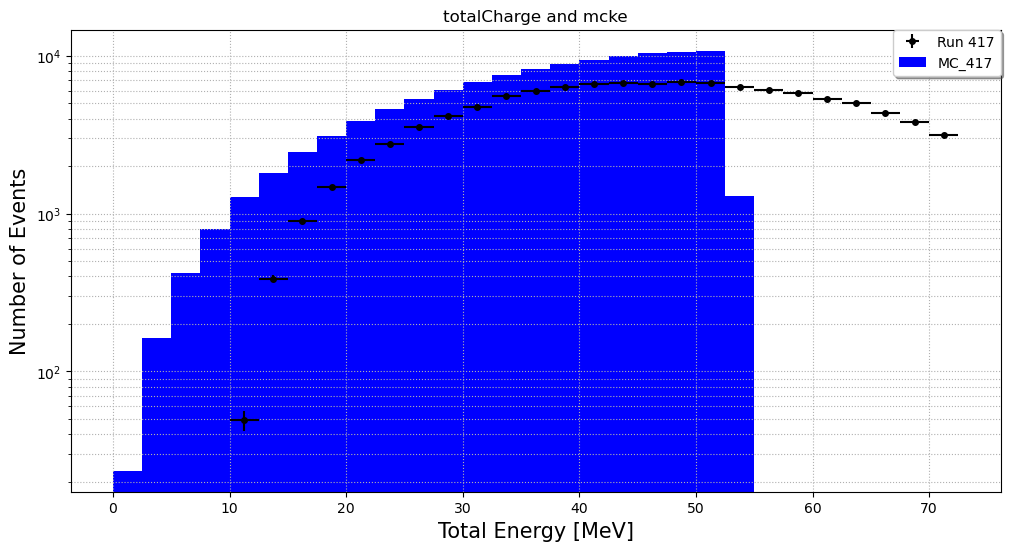

In [ ]:
run417_energy = (run417_charge/m)

plot_hist(run417_energy[bool_run417],[0,75],2.5,title="totalCharge and mcke",xlabel="Total Energy [MeV]",data_label="Run 417",mc_data=flat_mc_energy[bool_mc417],mc_label="MC_417",bool_log=True,bool_error=True)
#plot_hist(run417_energy[bool_run417]+b,[0,75],2.5,title="totalCharge vs mcke(Postive Shift)",xlabel="Total Energy [MeV]",data_label="Run 417",mc_data=flat_mc_energy,mc_label="MC_417",bool_log=True,bool_error=True)
#plot_hist(run417_energy[bool_run417]-b,[0,75],2.5,title="totalCharge vs mcke(Negative Shift)",xlabel="Total Energy [MeV]",data_label="Run 417",mc_data=flat_mc_energy,mc_label="MC_417",bool_log=True,bool_error=True)

Scaling MC by:  0.014628691380209452


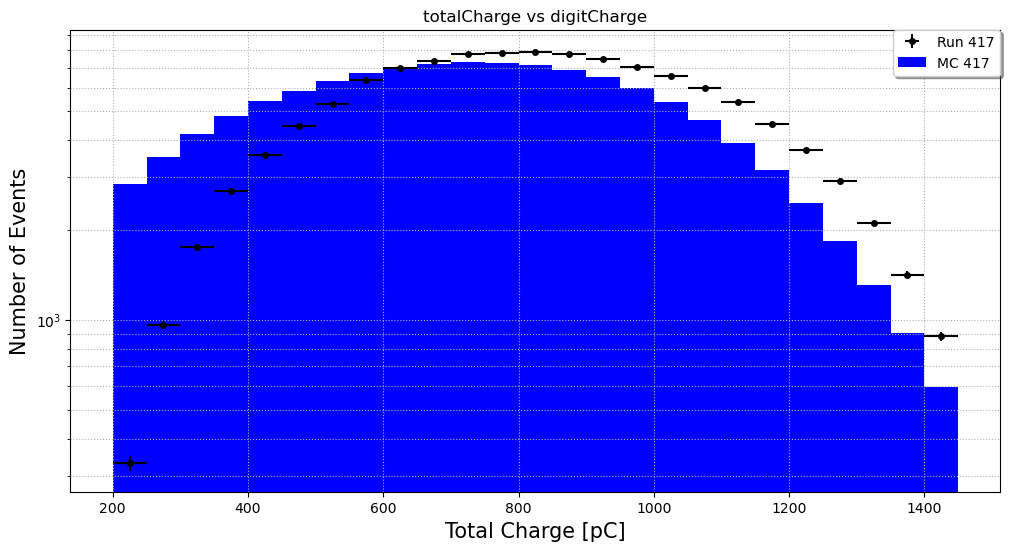

Scaling MC by:  0.01327352614020516


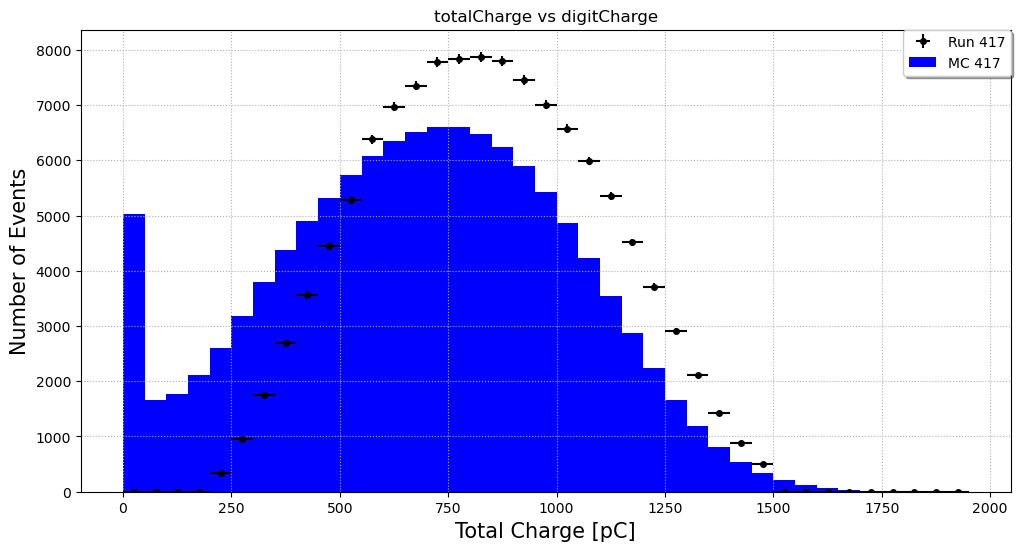

In [ ]:
plot_hist(run417_charge[bool_run417],[200,1500],50,title="totalCharge vs digitCharge",xlabel="Total Charge [pC]",data_label="Run 417",mc_data=flat_mc_charge[bool_mc417],mc_label="MC 417",bool_log=True,bool_error=True)
plot_hist(run417_charge[bool_run417],[0,2000],50,title="totalCharge vs digitCharge",xlabel="Total Charge [pC]",data_label="Run 417",mc_data=flat_mc_charge[bool_mc417],mc_label="MC 417",bool_log=False,bool_error=True)

Scaling MC by:  0.013273506969329971


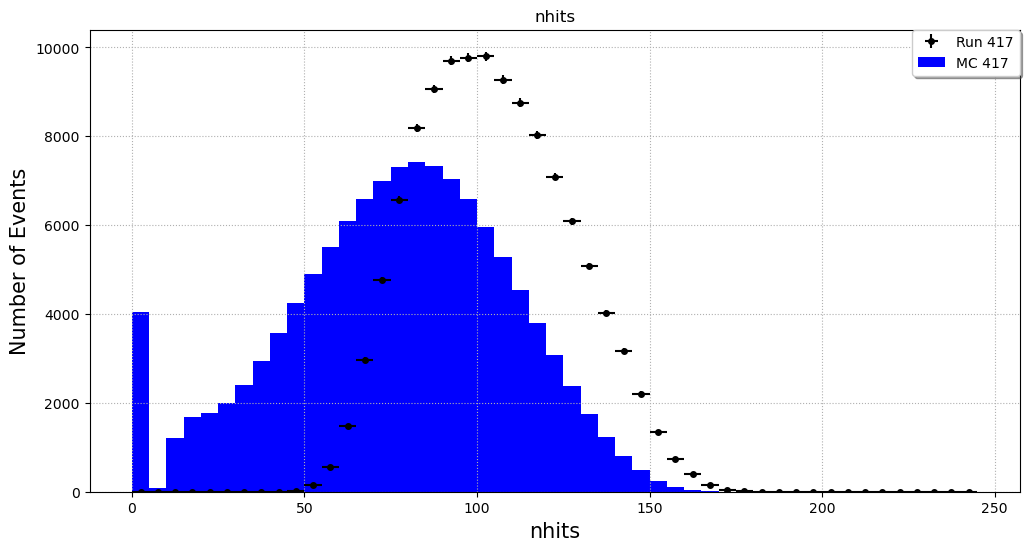

Scaling MC by:  0.013273506969329971


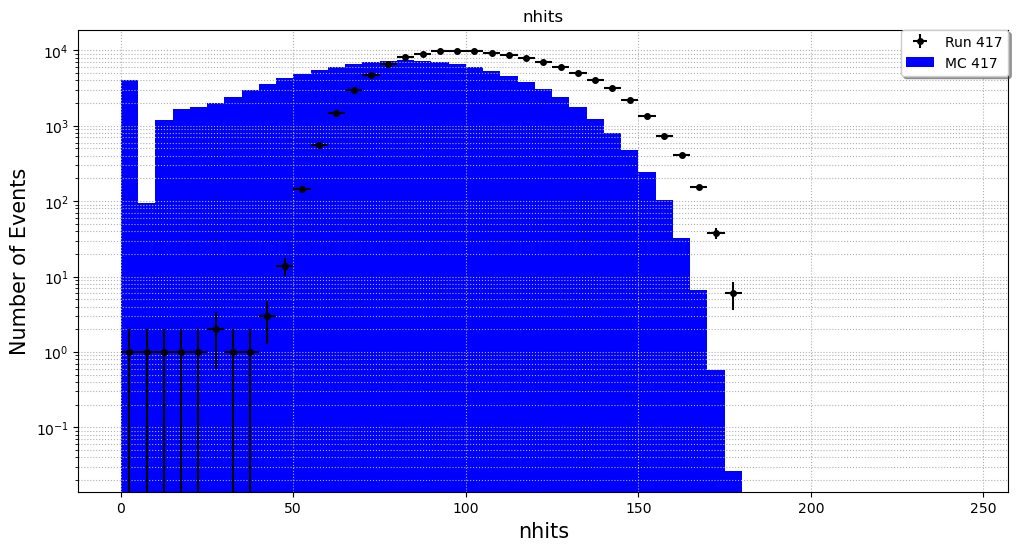

In [ ]:
plot_hist(run417_nhits[bool_run417],[0,250],5,title="nhits",xlabel="nhits",data_label="Run 417",mc_data=mc417_nhits,mc_label="MC 417",bool_log=False,bool_error=True)
plot_hist(run417_nhits[bool_run417],[0,250],5,title="nhits",xlabel="nhits",data_label="Run 417",mc_data=mc417_nhits,mc_label="MC 417",bool_log=True,bool_error=True)

In [ ]:
mc_current_rdf = get_RDF(path_name="/data/ahicks3/projects/eos/michelElectron/MC/MC_11M_Current/")

# Extract mc_branches
mc_current_nhits = mc_current_rdf.AsNumpy(columns=["digitNhits"])["digitNhits"]
mc_current_carge = mc_current_rdf.AsNumpy(columns=["digitCharge"])["digitCharge"]
flat_mc_CurrentCharge = flat(mc_current_carge,isSum=True)

Scaling MC by:  0.010234881953670453


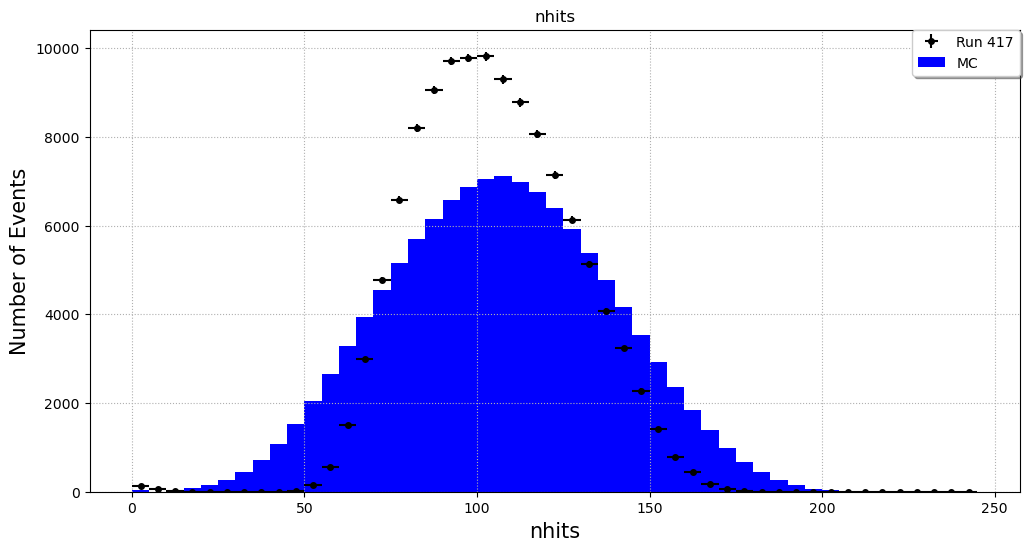

Scaling MC by:  0.010234881953670453


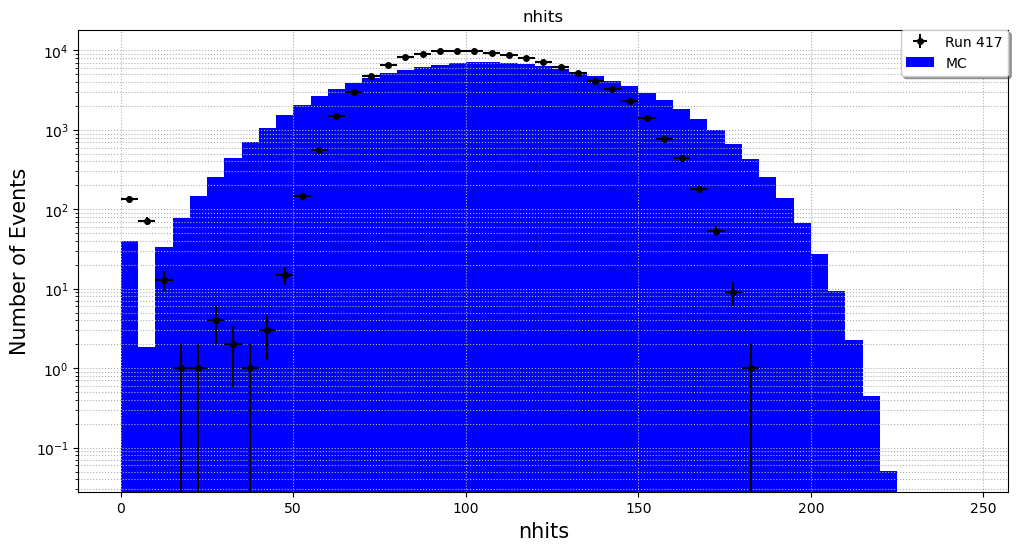

In [ ]:
plot_hist(run417_nhits[bool_run417],[0,250],5,title="nhits",xlabel="nhits",data_label="Run 417",mc_data=mc_current_nhits,mc_label="MC",bool_log=False,bool_error=True)
plot_hist(run417_nhits[bool_run417],[0,250],5,title="nhits",xlabel="nhits",data_label="Run 417",mc_data=mc_current_nhits,mc_label="MC",bool_log=True,bool_error=True)